# Importations of the libraries

In [7]:
import os
from glob import glob
import random
import time
import datetime

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline

from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

In [8]:
import torch

In [9]:
import torch.nn as nn
import torch.optim as optim



# Importation of the dataset

In [4]:
dataset = pd.read_csv('./data/driver_imgs_list.csv')
dataset.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

From the csv file, I'll use the classname as the labels for the images and use the image names to match the labels with the correct images.

## Import Driver dataset

In [5]:
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()
print(unique_drivers)

dict_keys(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081'])


In [6]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('.', 'data', 'imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('.', 'data', 'imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]


In [7]:
img_rows = 64
img_cols = 64
color_type = 1

In [8]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:08<01:18,  8.67s/it]

Loading directory c1


 20%|██        | 2/10 [00:15<01:05,  8.24s/it]

Loading directory c2


 30%|███       | 3/10 [00:22<00:54,  7.79s/it]

Loading directory c3


 40%|████      | 4/10 [00:29<00:45,  7.53s/it]

Loading directory c4


 50%|█████     | 5/10 [00:36<00:36,  7.32s/it]

Loading directory c5


 60%|██████    | 6/10 [00:43<00:28,  7.21s/it]

Loading directory c6


 70%|███████   | 7/10 [00:50<00:21,  7.07s/it]

Loading directory c7


 80%|████████  | 8/10 [00:56<00:13,  6.79s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:02<00:06,  6.50s/it]

Loading directory c9


100%|██████████| 10/10 [01:08<00:00,  6.82s/it]

Data Loaded in 68.22499012947083 second
Train shape: (17939, 64, 64, 1)
17939 train samples


In [9]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|          | 193/79726 [00:00<04:23, 302.20it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


## Statistics

In [10]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("./data/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('.', 'data','imgs', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


## Dataset visualization

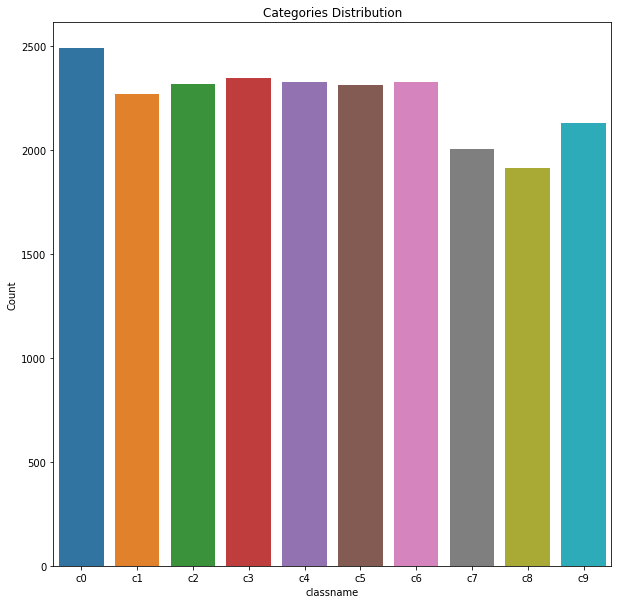

In [11]:
# Plot figure size
plt.figure(figsize = (10,10))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

In [12]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
drivers_id

driver_id  Counts
0       p021    1237
1       p022    1233
2       p024    1226
3       p026    1196
4       p016    1078
5       p066    1034
6       p049    1011
7       p051     920
8       p014     876
9       p015     875
10      p035     848
11      p047     835
12      p081     823
13      p012     823
14      p064     820
15      p075     814
16      p061     809
17      p056     794
18      p050     790
19      p052     740
20      p002     725
21      p045     724
22      p039     651
23      p041     605
24      p042     591
25      p072     346

## Images overview

In [13]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

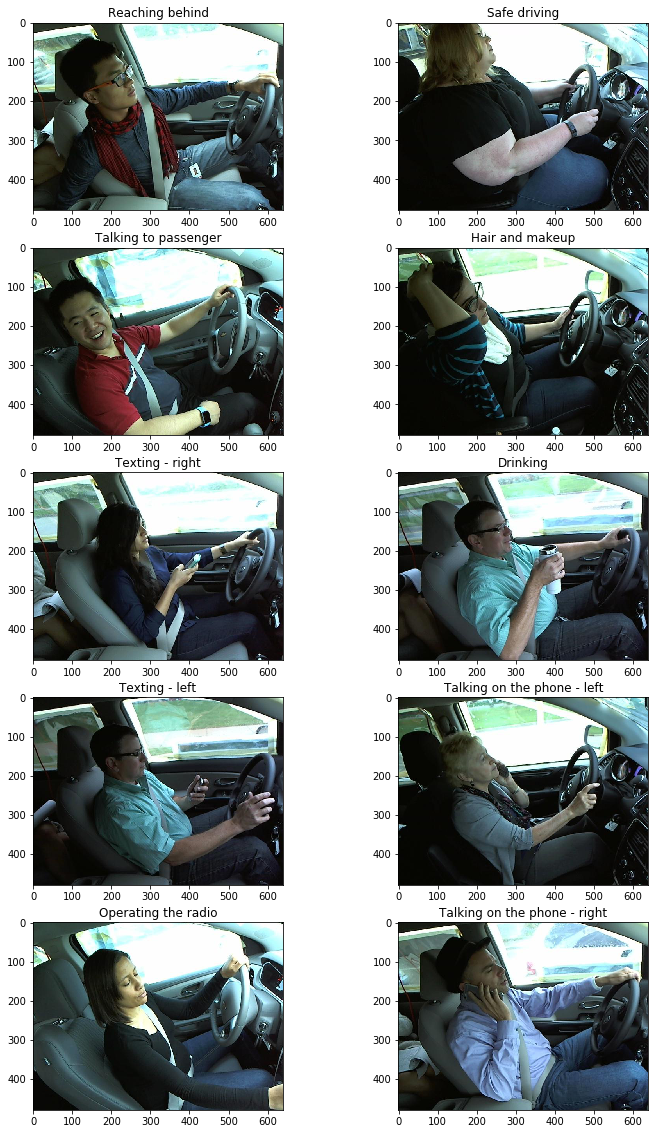

In [14]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = './data/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [15]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

# Building a Pytorch CNN 

In [37]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        self.drop_out = nn.Dropout(0.5)
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(8192, 500)
        self.relu = nn.ReLU()
    
        self.fc2 = nn.Linear(500, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x.float())) 
        print(x.size())
        x = self.pool(x) 
        print(x.size())
        
        x = self.relu(self.conv2(x)) 
        x = self.pool(x) 
        print(x.size())
        
        x = self.relu(self.conv3(x)) 
        x = self.pool(x) 
        print(x.size())

        
        x = self.relu(self.conv4(x)) 
        x = self.pool(x) 
        print(x.size())
        
        x = self.drop_out(x)
        print(x.size())
        
        x = self.flat(x)
        print(x.size())
        
        x = self.relu(self.fc1(x))
        print(x.size())
        
        x = self.drop_out(x) 
        print(x.size())
        
        x = self.softmax(self.fc2(x))
        print(x.size())
        
        return x
        

In [38]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)

test = torch.randn(1,1,64,64,)
print(test)
print(model(test))

tensor([[[[ 4.2795e-01,  2.7938e+00,  4.6542e-01,  ...,  3.1583e+00,
            5.6062e-01, -1.5520e+00],
          [ 3.7659e-01,  1.0318e+00,  1.1749e+00,  ..., -7.0724e-04,
           -1.4540e+00, -2.7261e-01],
          [-2.1138e+00,  1.4422e-01,  1.5945e-01,  ...,  2.1371e+00,
            2.0324e-01,  8.7324e-02],
          ...,
          [ 1.5148e+00,  1.7868e-01,  1.1039e+00,  ..., -1.9138e+00,
            1.1967e+00, -3.9658e-03],
          [ 5.4856e-01, -1.9119e-01, -6.5690e-01,  ..., -2.5201e-01,
           -1.0342e-01,  1.9595e-01],
          [-2.9976e-01, -2.5118e-01, -4.7133e-01,  ...,  1.0643e+00,
            5.9119e-01,  1.2388e-01]]]])
torch.Size([1, 64, 64, 64])
torch.Size([1, 64, 32, 32])
torch.Size([1, 128, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 8192])
torch.Size([1, 500])
torch.Size([1, 500])
torch.Size([1, 10])
tensor([[0.0954, 0.0933, 0.0924, 0.1016, 0.0997, 0.1088, 0.1007, 0.1051, 0.1009,
         

In [34]:
x_train.shape

(17939, 64, 64, 1)

In [50]:
x_train_torch = torch.from_numpy(x_train.transpose(0, 3, 1, 2))
print(x_train_torch.shape)
x_test_torch = torch.from_numpy(x_test.transpose(0, 3, 1, 2))
print(x_test_torch.shape)
y_train_torch = torch.from_numpy(y_train)
print(y_train_torch.shape)
y_test_torch = torch.from_numpy(y_test)
print(y_test_torch.shape)
print(y_test_torch[0])

torch.Size([17939, 1, 64, 64])
torch.Size([4485, 1, 64, 64])
torch.Size([17939, 10])
torch.Size([4485, 10])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)


In [60]:
nb_of_batches = 40
batch_size = int(round(17939/nb_of_batches, 0) +1)

for epoch in tqdm(range(2)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in tqdm(range(nb_of_batches)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = x_train_torch[i:min(i+batch_size,x_test_torch.shape[0])] , y_train_torch[i:min(i+batch_size,x_test_torch.shape[0])]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        print("loss")
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  2%|▎         | 1/40 [00:16<10:30, 16.17s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  5%|▌         | 2/40 [00:30<09:54, 15.63s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  8%|▊         | 3/40 [00:44<09:22, 15.20s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 10%|█         | 4/40 [01:00<09:16, 15.47s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 12%|█▎        | 5/40 [01:15<08:52, 15.21s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 15%|█▌        | 6/40 [01:29<08:29, 14.99s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 18%|█▊        | 7/40 [01:44<08:06, 14.75s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 20%|██        | 8/40 [02:00<08:07, 15.23s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 22%|██▎       | 9/40 [02:17<08:10, 15.84s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 25%|██▌       | 10/40 [02:35<08:12, 16.41s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 28%|██▊       | 11/40 [02:50<07:46, 16.08s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 30%|███       | 12/40 [03:09<07:51, 16.85s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 32%|███▎      | 13/40 [03:26<07:39, 17.03s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 35%|███▌      | 14/40 [03:41<07:00, 16.18s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 38%|███▊      | 15/40 [03:55<06:28, 15.55s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 40%|████      | 16/40 [04:09<06:01, 15.08s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 42%|████▎     | 17/40 [04:23<05:40, 14.79s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 45%|████▌     | 18/40 [04:37<05:19, 14.54s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 48%|████▊     | 19/40 [04:51<05:03, 14.45s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 50%|█████     | 20/40 [05:05<04:46, 14.34s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 52%|█████▎    | 21/40 [05:19<04:31, 14.28s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 55%|█████▌    | 22/40 [05:33<04:15, 14.20s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 57%|█████▊    | 23/40 [05:49<04:08, 14.64s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 60%|██████    | 24/40 [06:03<03:52, 14.54s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 62%|██████▎   | 25/40 [06:17<03:36, 14.46s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 65%|██████▌   | 26/40 [06:31<03:20, 14.33s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 68%|██████▊   | 27/40 [06:46<03:05, 14.26s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 70%|███████   | 28/40 [07:00<02:51, 14.33s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 72%|███████▎  | 29/40 [07:15<02:39, 14.52s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 75%|███████▌  | 30/40 [07:30<02:26, 14.62s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 78%|███████▊  | 31/40 [07:44<02:09, 14.44s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 80%|████████  | 32/40 [07:58<01:54, 14.30s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 82%|████████▎ | 33/40 [08:12<01:39, 14.25s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 85%|████████▌ | 34/40 [08:26<01:25, 14.18s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 88%|████████▊ | 35/40 [08:40<01:11, 14.23s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 90%|█████████ | 36/40 [08:54<00:56, 14.19s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 92%|█████████▎| 37/40 [09:14<00:47, 15.67s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 95%|█████████▌| 38/40 [09:28<00:30, 15.35s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 98%|█████████▊| 39/40 [09:45<00:15, 15.75s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  2%|▎         | 1/40 [00:15<10:17, 15.85s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  5%|▌         | 2/40 [00:33<10:25, 16.45s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



  8%|▊         | 3/40 [00:50<10:08, 16.44s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 10%|█         | 4/40 [01:04<09:34, 15.95s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 12%|█▎        | 5/40 [01:23<09:49, 16.83s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 15%|█▌        | 6/40 [01:40<09:35, 16.91s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 18%|█▊        | 7/40 [01:55<08:57, 16.29s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 20%|██        | 8/40 [02:09<08:20, 15.63s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 22%|██▎       | 9/40 [02:23<07:50, 15.16s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 25%|██▌       | 10/40 [02:37<07:23, 14.79s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 28%|██▊       | 11/40 [02:51<07:01, 14.54s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 30%|███       | 12/40 [03:05<06:42, 14.37s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 32%|███▎      | 13/40 [03:19<06:26, 14.30s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 35%|███▌      | 14/40 [03:34<06:10, 14.27s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 38%|███▊      | 15/40 [03:48<05:55, 14.21s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 40%|████      | 16/40 [04:02<05:40, 14.19s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 42%|████▎     | 17/40 [04:16<05:25, 14.17s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 45%|████▌     | 18/40 [04:30<05:11, 14.16s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 48%|████▊     | 19/40 [04:44<04:57, 14.17s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 50%|█████     | 20/40 [04:58<04:43, 14.15s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 52%|█████▎    | 21/40 [05:13<04:29, 14.17s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 55%|█████▌    | 22/40 [05:28<04:19, 14.43s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 57%|█████▊    | 23/40 [05:42<04:04, 14.36s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 60%|██████    | 24/40 [05:56<03:48, 14.28s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 62%|██████▎   | 25/40 [06:10<03:33, 14.23s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 65%|██████▌   | 26/40 [06:24<03:18, 14.19s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 68%|██████▊   | 27/40 [06:40<03:10, 14.67s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 70%|███████   | 28/40 [06:54<02:54, 14.55s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 72%|███████▎  | 29/40 [07:08<02:38, 14.39s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 75%|███████▌  | 30/40 [07:22<02:23, 14.34s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 78%|███████▊  | 31/40 [07:37<02:08, 14.27s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 80%|████████  | 32/40 [07:51<01:53, 14.20s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 82%|████████▎ | 33/40 [08:05<01:38, 14.14s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 85%|████████▌ | 34/40 [08:19<01:24, 14.15s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 88%|████████▊ | 35/40 [08:35<01:13, 14.72s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 90%|█████████ | 36/40 [08:50<00:59, 14.82s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 92%|█████████▎| 37/40 [09:04<00:43, 14.52s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 95%|█████████▌| 38/40 [09:17<00:28, 14.29s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



 98%|█████████▊| 39/40 [09:31<00:14, 14.15s/it]

torch.Size([449, 64, 64, 64])
torch.Size([449, 64, 32, 32])
torch.Size([449, 128, 16, 16])
torch.Size([449, 256, 8, 8])
torch.Size([449, 512, 4, 4])
torch.Size([449, 512, 4, 4])
torch.Size([449, 8192])
torch.Size([449, 500])
torch.Size([449, 500])
torch.Size([449, 10])
loss



100%|██████████| 2/2 [19:47<00:00, 593.51s/it]

Finished Training


In [61]:
y_pred = model(x_test_torch)

torch.Size([4485, 64, 64, 64])
torch.Size([4485, 64, 32, 32])
torch.Size([4485, 128, 16, 16])
torch.Size([4485, 256, 8, 8])
torch.Size([4485, 512, 4, 4])
torch.Size([4485, 512, 4, 4])
torch.Size([4485, 8192])
torch.Size([4485, 500])
torch.Size([4485, 500])
torch.Size([4485, 10])


In [62]:
y_pred[0]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<SelectBackward>)

In [23]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.5)
        self.drop3 = nn.Dropout(0.25)


        ## CNN 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32, affine=False)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        ## CNN 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64, affine=False)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        ## CNN 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128, affine=False)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        ## Output
        self.flat = nn.Flatten()
        
        self.fc1 = nn.Linear(8192, 512)
        self.batchnorm4 = nn.BatchNorm1d(512, affine=False)

        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        
        ## CNN 1
        x = self.relu(self.conv1(x.float())) 
        print(x.size())
        x = self.batchnorm1(x) 
        print(x.size())
        
        x = self.relu(self.conv2(x)) 
        x = self.batchnorm1(x) 
        print(x.size())
        
        x = self.pool(x) 
        x = self.drop1(x)
        print(x.size())
        
        
        ## CNN 2
        x = self.relu(self.conv3(x)) 
        x = self.batchnorm2(x)
        print(x.size())
        
        x = self.relu(self.conv4(x)) 
        x = self.batchnorm2(x) 
        print(x.size())
        
        x = self.pool(x) 
        x = self.drop1(x)
        print(x.size())
        
        ## CNN 3
        x = self.relu(self.conv5(x)) 
        x = self.batchnorm3(x)
        print(x.size())
        
        x = self.relu(self.conv6(x)) 
        x = self.batchnorm3(x) 
        print(x.size())
        
        x = self.pool(x) 
        x = self.drop2(x)
        print(x.size())
        
        ## OUTPUT 
        x = self.flat(x)
        print(x.size())
        
        x = self.relu(self.fc1(x))
        print(x.size())
        
        x = self.batchnorm4(x)
        print(x.size())
        
        x = self.drop2(x)
        print(x.size())
        
        x = self.relu(self.fc2(x))
        x = self.drop3(x)
        print(x.size())

        
        x = self.softmax(self.fc3(x))
        print(x.size())
        
        return x
        

In [25]:
model2 = ConvNet2()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.RMSprop(model2.parameters(), lr=0.001, alpha=0.9, eps=1e-07, weight_decay=0, momentum=0, centered=False)

test2 = torch.randn(2,1,64,64,)
print(test2)
print(model2(test2))

tensor([[[[-9.9552e-01, -4.2950e-01, -9.3583e-01,  ...,  1.0919e+00,
           -8.2856e-01,  6.1776e-01],
          [-7.0893e-01, -7.8719e-01, -1.0602e+00,  ..., -8.8499e-01,
            7.6637e-01, -1.1863e+00],
          [-8.5880e-02, -7.5233e-02, -9.1146e-01,  ..., -2.5526e-01,
           -1.6545e-01, -7.3809e-01],
          ...,
          [-1.1045e+00, -8.1674e-02,  9.0744e-01,  ...,  6.0063e-01,
            4.9392e-01,  1.1813e+00],
          [ 3.6127e-01,  6.9364e-01, -1.3268e+00,  ...,  1.1049e+00,
            4.8340e-01, -3.0415e-01],
          [ 4.5019e-01, -1.2773e+00,  6.3144e-01,  ...,  1.8230e+00,
           -2.0645e-01, -7.6416e-01]]],


        [[[ 8.5389e-01, -5.5197e-01, -3.5637e-01,  ...,  1.8680e-01,
            2.6599e+00,  2.8359e+00],
          [-2.9463e-02,  2.9304e-01, -1.1898e+00,  ...,  1.6477e-01,
            2.0786e+00,  1.4817e+00],
          [ 1.2592e+00,  2.4619e-02,  1.4335e+00,  ...,  6.1088e-01,
            2.0229e+00,  1.2989e+00],
          ...,
   